# Summary

We will use PyMC3 to estimate the posterior PDF for the true rating of a set of artificial teams using data from a simulated season. The idea is to test our model on a small set of artificial data where we know the answer to begin with, so we can learn about MCMC and make sure our model is sensible.

In [1]:
import pandas as pd
import os
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Suppose our fake league has 3 fake teams.
 1. One team of all stars that we expect to win most of their games.
 2. One average team.
 3. One team that is just out there to have fun.

In [2]:
true_rating = {
    'All Stars': 2.0,
    'Average': 0.0,
    'Just Having Fun': -1.2,
}

Assign an index number to each team in the league. We will need this later on when modeling the true skill of each team.

In [3]:
true_index = {
    0: 'All Stars',
    1: 'Average',
    2: 'Just Having Fun',
}

Calculate the number of teams in the league and assign variables to the list of team numbers and team names.

In [4]:
n_teams = len(true_rating)
team_numbers = range(n_teams)
team_names = [true_index[i] for i in team_numbers]

Now let's define a function that will produce a simulated season between these teams given a season length.

In [5]:
def simulate_season(season_length):
    
    # instantiate the a list of games
    game_rows = []
    
    # loop over each game in the simulated season
    for game in range(season_length):
        
        # each game has the team name and index for both teams as well as the game outcome.
        game_row = {}
        
        # select the two teams for this game via random selection
        matchup = np.random.choice(team_numbers, size=2, replace=False)
        
        # team0 is Team A, team1 is Team B
        team0 = true_index[matchup[0]]
        team1 = true_index[matchup[1]]
        game_row['Team A'] = team0
        game_row['Team B'] = team1
        game_row['Index A'] = matchup[0]
        game_row['Index B'] = matchup[1]

        # compute the rating differential between the two teams for this game
        deltaRating = true_rating[team0] - true_rating[team1]
        
        # model the probability that Team A wins using a sigmoid function
        p = 1 / (1 + np.exp(-deltaRating))

        # if p is larger than a random number between 0 and 1, then A wins
        randomNumber = np.random.random()
        outcome_A = p > randomNumber
        game_row['Team A Wins'] = outcome_A

        # append the game data
        game_rows.append(game_row)
    
    # convert to pandas dataframe for convenience with subsequent data processing
    season = pd.DataFrame(game_rows)
    
    return season


We'll test a variety of season lengths

In [6]:
season_lengths = [5, 20, 100]

Create simulated seasons

In [7]:
simulated_seasons = [simulate_season(season_length) for season_length in season_lengths]

Let's take a look at our 20 game season.

In [8]:
season = simulated_seasons[1]
season

,Index A,Index B,Team A,Team A Wins,Team B
0,0,1,All Stars,True,Average
1,1,0,Average,False,All Stars
2,0,2,All Stars,True,Just Having Fun
3,0,1,All Stars,False,Average
4,1,2,Average,True,Just Having Fun
5,1,0,Average,False,All Stars
6,2,0,Just Having Fun,False,All Stars
7,0,1,All Stars,True,Average
8,2,0,Just Having Fun,False,All Stars
9,1,2,Average,True,Just Having Fun


Look at the results in an aggregate sense.

In [9]:
season_grouped = season.groupby(["Index A", "Index B"])
season_results = season_grouped.sum().join(season_grouped.count(), rsuffix="1")
season_tidy = season_results.drop(["Team A Wins1", "Team B"], axis=1).rename(columns={"Team A": "Total Games"})

In [10]:
season_tidy

Team A Wins  Total Games
Index A Index B                          
0       1                5.0            6
        2                4.0            4
1       0                0.0            2
        2                2.0            2
2       0                1.0            6

This table is a bit hard to read because there is no duplication of data (i.e., you have to compare 0 vs 1 and 1 vs. 0 to get all of the games between those teams). Team 0 (all-stars) beat team 1 (average) 4/5 times and team 2 (just having fun) 5/5 times. Team 1 beat team 2 6/10 times.

In [11]:
# expected probability of team 0 beating team 1
1 / (1 + np.exp(-2))

0.88079707797788231

In [12]:
# expected probability of team 0 beating team 2
1 / (1 + np.exp(-3.2))

0.96083427720323566

In [13]:
# expected probability of team 1 beating team 2
1 / (1 + np.exp(-1.2))

0.76852478349901754

Naively we would have expected p = 1 / (1 + exp(-2)) = 0.88 for team 0 vs team 1, p = 1 / (1 + exp(-3.2)) = 0.96 for team 0 vs. team 2, and p = 1 / (1 + exp(-1.2)) = 0.77 for team 1 vs team 2. We got pretty close to our expectation (by design!).

Next, let's define a function that builds the model given a season's worth of data.

In [19]:
def model_season(season):
    
    # PyMC3 models use "with" to provide the context for the model
    with pm.Model() as model:
        
        # the prior on each team's true skill is a Normal(0, 1)
        skills = pm.Normal('skills', mu=0, sd=1, shape=n_teams)
        
        # the index of team A and team B
        index_A = season['Index A'].values
        index_B = season['Index B'].values

        # the differential in skills between two teams is what matters
        delta_skill = skills[index_A] - skills[index_B]

        # same sigmoid model for converting skill differential to a probability that Team A wins
        p = 1 / (1 + np.exp(-delta_skill))

        # relate the likelihood to the outcomes using the Bernoulli distribution
        win = pm.Bernoulli('win', p, observed=season['Team A Wins'].values)
        
        # sample using the default PyMC3 settings, take 1000 samples after burn-in
        trace = pm.sample(1000)
        
    return trace

Next, we build a list of traces, one for each season_length.

In [15]:
# the traces list stores the model outcomes for each season
traces = [model_season(season) for season in simulated_seasons]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [skills]
100%|██████████| 1500/1500 [00:01<00:00, 1148.69it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [skills]
100%|██████████| 1500/1500 [00:01<00:00, 1372.05it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [skills]
100%|██████████| 1500/1500 [00:01<00:00, 1088.72it/s]


Now let's inspect the results with some visualizations!

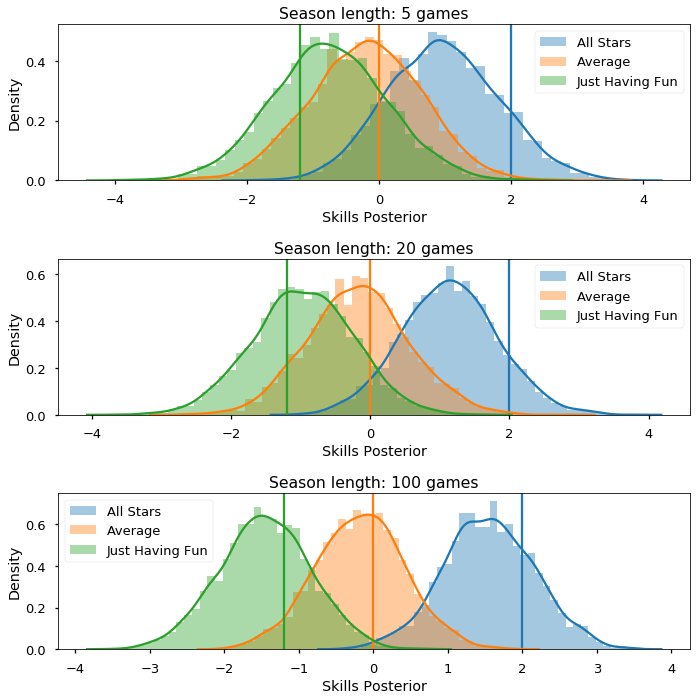

In [16]:
sns.set_context('talk')
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
current_palette = sns.color_palette()
# plt.figure(figsize=(10, 5))
for ax_index, n_games in enumerate(season_lengths):
    ax = axes[ax_index]
    for team_number in team_numbers:
        skills_posterior = traces[ax_index]['skills'][:, team_number]
        team_name = true_index[team_number]
        a = sns.distplot(skills_posterior, label=team_name, ax=ax, color=current_palette[team_number])
        ax.axvline(true_rating[team_name], color=current_palette[team_number])
    ax.legend()
    ax.set_xlabel('Skills Posterior')
    ax.set_ylabel('Density')
    ax.set_title("Season length: {} games".format(n_games))
plt.tight_layout()

Hmm, something looks odd here. Even when we have a 100 game season, the posterior pdfs for the "Average" team and the "Just Having Fun" team show significant overlap. Does this mean that our model is not sure about which team is better? Remember that what matters is the difference in skill levels between two teams. Let's take a look at the difference in skill levels between these two teams.

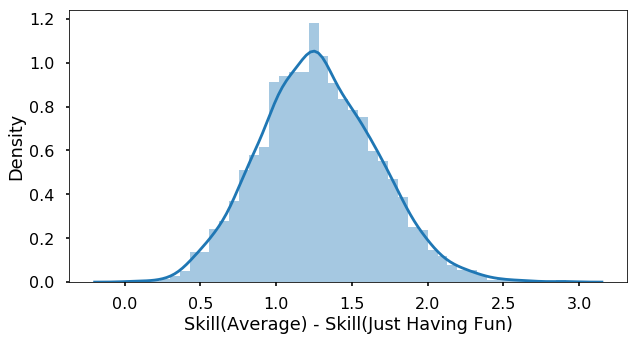

In [17]:
# pick the trace with the 100 game season
trace = traces[-1]

# make the plot look about the right size
sns.set_context('poster')
plt.figure(figsize=(10, 5))

# team 1 is the "Average" team, team 2 is the "Just Having Fun" team
skill_delta = trace['skills'][:, 1] - trace['skills'][:, 2]

# seaborn makes nice density plots
sns.distplot(skill_delta)
plt.xlabel('Skill(Average) - Skill(Just Having Fun)')
plt.ylabel('Density')

Let's calculate the percentage of samples where team "Average" has a higher skill than team "Just Having Fun".

In [18]:
gt0 = skill_delta > 0
print("Percentage of samples where team 'Average' has a higher rating than 'Just Having Fun': {:.2f}%".format(
    100. * skill_delta[gt0].size / skill_delta.size))

Percentage of samples where team 'Average' has a higher rating than 'Just Having Fun': 100.00%


Ah, so the posterior pdf is actually quite clear: There is a 99.62% chance that team "Average" is better than "Just Having Fun".